# Lecture 8: Score-based Models (Score Matching and Flow Matching)

Extending the diffusion concept to infinitely many steps introduces the challenge of handling continuous time, which requires the use of differential equations. Score-based models provide an elegant alternative to diffusion models by focusing directly on estimating the gradients of data distributions—referred to as scores. These gradients enable a continuous transformation from noise to data, forming the foundation for building continuous-time generative models. This approach not only simplifies the framework but also offers a unique mechanism for transforming noise into data.

For this task, we will build and train a **Score-based Model**:

- **Score-based Model**: A type of generative model that learns to generate data by estimating the score (gradient of the data distribution) and using it to transform noise into data.
  - **Score Matching**: A technique to train the model by matching the score of the data distribution.
  - **Flow Matching**: A technique to train the model by matching the flow of the data distribution.

One key tool utilized in Score-based Models is **Stochastic Gradient Langevin Dynamics (SGLD)** [1]. SGLD is a method for sampling from the real data distribution, $p_{\text{real}}(x)$, by iteratively refining a randomly initialized point in the data space. Starting with $\hat{x}$, where $p_{\text{real}}(\hat{x}) \approx 0$, the process updates this point to move it toward regions of higher probability. The update rule is given by:

$$
x_{t+\Delta t} = x_t + \alpha \nabla_{x_t} \ln p_{\text{real}}(x_t) + \eta \epsilon,
$$

where:
- $x_t$: Current sample at time $t$,
- $\nabla_{x_t} \ln p_{\text{real}}(x_t)$: Gradient of the log-probability at $x_t$, guiding the sample toward high-probability regions,
- $\alpha > 0$: Step size controlling the gradient update magnitude,
- $\eta > 0$: Scaling factor for the noise term,
- $\epsilon \sim \mathcal{N}(0, I)$: Gaussian noise ensuring exploration of the data space.

Through this iterative process, SGLD generates samples that align with $p_{\text{real}}(x)$, effectively transforming noise into realistic data.

By the end of this notebook, you’ll understand how to:
1. Build and train a score-based model using PyTorch.
2. Sample from a Score Matching Model.
3. sample from a Flow Matching Model.

Let’s dive in and start building!

---

#### References
<div style="font-size: smaller;">  
[1] Welling, M., & Teh, Y. W. (2011). Bayesian learning via stochastic gradient Langevin dynamics. In Proceedings of the 28th international conference on machine learning (ICML-11) (pp. 681-688).
</div>

### Step 1: Import Libraries and Create a Dataset of 2D Points

In this step, we will import the necessary libraries and create a dataset of 2D points that form a smiley face. This dataset will be used to train our Denoising Diffusion Model. Using a simpler dataset reduces the computational requirements of this notebook, but allow for a better visual representation of how these models work.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

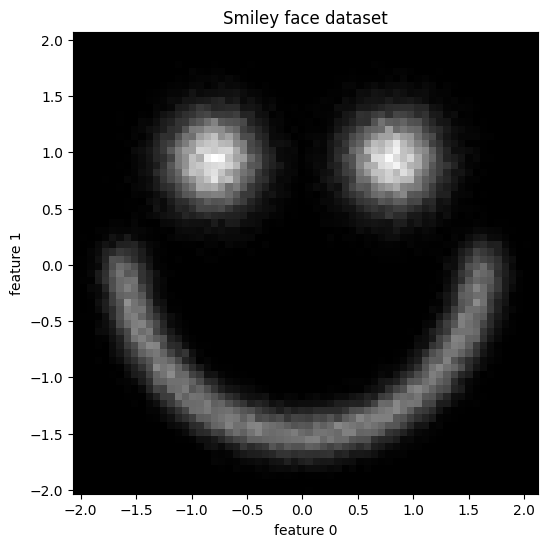

In [2]:
### Code based on https://bm371613.github.io/conditional-flow-matching/ ###

def create_dataset(size: int = 100000):
    '''
    Create a dataset of size `size` of 2D points that have a shape of a smiley face.
    Args:
        size: int: The number of points to generate.
    Returns:
        torch.Tensor: The generated dataset.
    '''
    complex_points = torch.polar(torch.tensor(1.0), torch.rand(size) * 2 * torch.pi)
    X = torch.stack((complex_points.real, complex_points.imag)).T
    upper = complex_points.imag > 0
    left = complex_points.real < 0
    X[upper, 1] = 0.5
    X[upper & left, 0] = -0.5
    X[upper & ~left, 0] = 0.5
    noise = torch.zeros_like(X)
    noise[upper] = torch.randn_like(noise[upper]) * 0.10
    noise[~upper] = torch.randn_like(noise[~upper]) * 0.05
    X += noise
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return X + noise

def plot_dataset(X, bins, ax=None, verbose=True, **kwargs):
    '''
    Plot a 2D dataset.
    Args:
        X: torch.Tensor: The dataset to plot.
        bins: int: The number of bins to use for the histogram.
        ax: plt.Axes: The axes to plot on. If None, the current axes will be used.
        verbose: bool: Whether to show the axis labels.
        **kwargs: dict: Additional keyword arguments to pass to `ax.set`.
    '''
    if ax is None:
        ax = plt.gca()
    ax.hist2d(*X.T, bins=bins, cmap='gray')
    if verbose:
        ax.set_xlabel('feature 0')
        ax.set_ylabel('feature 1')
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set(**kwargs)

# Create the smiley face dataset and plot it.
dataset = create_dataset()
fig = plt.figure(figsize=(6, 6))
plot_dataset(dataset, bins=64, title='Smiley face dataset')

### Step 2: Define a suitable Score-based Model

1. The main requirement for a model capable of parametrizing these tasks is **Output Dimensionality**:
    - **The model's output must match the input dimensionality**. Each score corresponds directly to each pixel (or input feature), whether it's predicting gradients, noise values, or a vector field.

2. The second requirement is also straightforward an simple to ensure - **the model must take the time step as a conditioning input**.
    - The time step provides information about the diffusion/matching process stage, enabling the model to predict the appropriate scores or noise values.

3. This means that the **Model Architecture is flexible**. While U-Nets are commonly used for high-dimensional inputs like images, you can use any architecture that supports the task. Recent approaches even use transformers.
    - For this notebook, since the distribution we are modelling is not complex, we will use a **Multilayer Perceptron (MLP)** for faster training and inference. 

In [12]:
class ZeroToOneTimeEmbedding(nn.Module):

    def __init__(self, dim: int):
        '''
        Create a time embedding that maps time to a 2D embedding.
        Args:
            dim: int: The dimensionality of the embedding
        '''
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.register_buffer('freqs', torch.arange(1, dim // 2 + 1) * torch.pi)

    def forward(self, t):
        '''
        Forward pass of the time embedding.
        Args:
            t: torch.Tensor: The time to embed.
        Returns:
            torch.Tensor: The embedded time.
        '''
        emb = self.freqs * t[..., None]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
class MLP(nn.Module):
    def __init__(self, n_features, time_embedding_size=8, n_blocks=5):
        '''
        Create an MLP with residual connections.
        Args:
            n_features: int: The number of input and output features.
            time_embedding_size: int: The size of the time embedding to use.
            n_blocks: int: The number of residual blocks to use.
        '''
        super().__init__()
        self.time_embedding = ZeroToOneTimeEmbedding(time_embedding_size)
        hidden_size = n_features + time_embedding_size
        blocks = []
        for _ in range(n_blocks):
            blocks.append(nn.Sequential(
                nn.BatchNorm1d(hidden_size), # A batch norm layer would go here, taking an input size of `hidden_size`.
                nn.Linear(hidden_size,hidden_size), # A linear layer with hidden_size inputs and outputs.
                nn.ReLU(), # A ReLU activation.
            ))
        self.blocks = nn.ModuleList(blocks)
        self.final = nn.Linear(hidden_size, n_features) # A linear layer with hidden_size inputs and that outputs n_features.


    def forward(self, X, time):
        '''
        Forward pass of the model.
        Args:
            X: torch.Tensor: The input features.
            time: torch.Tensor: The time to embed.
        Returns:
            torch.Tensor: The output of the model.
        '''
        X = torch.cat([X, self.time_embedding(time)], axis=1)
        for block in self.blocks:
            X = X + block(X)
        X = self.final(X)
        return X

## Score Matching

One major challenge in applying SGLD is that the real data distribution, $ p_{\text{real}}(x) $, is unknown. While we could turn to generative models like GANs, VAEs, or normalizing flows to approximate $ p_{\text{real}}(x) $, there is an alternative approach. Upon closer examination of the SGLD update equation, we realize that $ p_{\text{real}}(x) $ itself is not necessary—what we truly need is the gradient of its logarithm, $ \nabla_x \ln p_{\text{real}}(x) $, known as the score function. The score function provides a vector field pointing toward the modes of the real data distribution. For example, in the case of a multimodal distribution, the score function can be visualized as vectors on a grid directing Langevin dynamics toward high-probability regions.

This insight allows reformulation: instead of modeling $ p_{\text{real}}(x) $, we focus on learning the score function. As a gradient, the score function shares the shape of $ x $ and can be represented as a vector. By learning $ s_\theta(x) $, we enable SGLD to produce samples that follow $ p_{\text{real}}(x) $ without explicitly modeling it. To achieve this, we optimize the difference between the true score function and a parameterized approximation $ s_\theta(x) $:

$$
\mathcal{L}(\theta) = \frac{1}{2} \int \|s_\theta(x) - \nabla_x \ln p_{\text{real}}(x)\|^2 p_{\text{real}}(x) \, dx.
$$

Directly using this objective is challenging because $ p_{\text{data}}(x) $ is a discrete distribution represented as a sum of Dirac delta functions, which is non-differentiable. To address this, small Gaussian noise with variance $ \sigma^2 $ is added to the data. Perturbed data is represented as $ \tilde{x}_n = x_n + \sigma \cdot \epsilon $, where $ \epsilon \sim \mathcal{N}(0, I) $. This transformation smooths $ p_{\text{data}}(x_n) $ into a Gaussian mixture. This smoothed distribution makes the optimization problem differentiable. Using the closed-form score function for a Gaussian distribution, the gradient of the log-likelihood with respect to $ \tilde{x}_n $ is:

$$
\nabla_{\tilde{x}} \ln \mathcal{N}(\tilde{x}_n | x_n, \sigma^2) = -\frac{1}{\sigma} \epsilon.
$$

Applying this result to the objective, we get the differentiable objective:

$$
\mathcal{L}(\theta) = \frac{1}{N} \sum_{n=1}^{N} \mathbb{E}_{N(\epsilon | 0, I)} \left[ \frac{1}{2\sigma^2} \left\| \epsilon - \tilde{s}_\theta(\tilde{x}) \right\|^2 \right],
$$

where $ \tilde{s}_\theta(x) = -\sigma s_\theta(\tilde{x}) $. Learning $ \tilde{s}_\theta(\tilde{x}) $ by optimizing this objective is referred to as score matching.

To extend this formulation to a time-dependent framework, we can modify the equation for $ \sigma_t $ to allow for time-dependent values of $ \sigma $ [2]. Specifically, we can express the time-dependent version of $ \sigma_t $ as:

$$
\sigma_t = \sqrt{\frac{\sigma_k^{2t} - 1}{2 \log(\sigma_k)}}
$$

In this version, $ \sigma_k $ is a constant.

---

#### References
<div style="font-size: smaller;">  
[2] Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2020). Score-based generative modeling through stochastic differential equations. arXiv preprint arXiv:2011.13456.
</div>



### Step 3: Train the Score Matching Model

1. **repeat**  
2. &nbsp;&nbsp;&nbsp;Sample $x \sim q(x)$  
3. &nbsp;&nbsp;&nbsp;Sample $t \sim \text{Uniform}(\{0, \dots, 1\})$  
4. &nbsp;&nbsp;&nbsp;Sample $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$  
5. &nbsp;&nbsp;&nbsp;Calculate the noisy version of the data: $ \tilde{x_t} = x + \sigma_t \cdot \epsilon $.
6. &nbsp;&nbsp;&nbsp;Calculate the score $ \tilde{s}_\theta(\tilde{x}) $. 
7. &nbsp;&nbsp;&nbsp;Take a gradient descent step on $\nabla_\theta \frac{1}{2\sigma^2} \| \epsilon - \tilde{s}_\theta(\tilde{x}) \|^2$  
8. **until converged**


In [13]:
def sigma_t(sigma_k, t):
    """Compute the sigma for a certain t.

    Args: 
        sigma_k: The $\sigma_k$ in our SDE.    
        t: A vector of time steps. 

    Returns:
        The ssigma_t.
    """
    sigma1 = torch.sqrt((torch.pow(torch.tensor(sigma_k),2*t))/(2*torch.log(torch.tensor(sigma_k))))
    return sigma1# Implement this function to return the sigma_t based on the formula in the text.

def score_matching_loss(model, x, sigma_k=25):
    """The loss function for training score-based generative models.

    Args:
        model: A PyTorch model instance that represents a 
        time-dependent score-based model.
        x: A mini-batch of training data. 
        sigma_k: The $\sigma_k$ in our SDE.   
    """
    t = torch.rand(size=(x.shape[0],), device=x.device)  
    z = torch.randn_like(x)
    sigma = sigma_t(sigma_k, t)
    perturbed_x = x + z * sigma[:, None]
    score = model(perturbed_x, t)
    return torch.mean(torch.sum((score * sigma[:, None] + z)**2, dim=(1)))

def training_loop(model, sigma_k, n_steps, batch_size, lr):
    '''
    Train a model.
    Args:
        model: nn.Module: The model to train.
        sigma_k: float: The $\sigma_k$ parameter to use.
        n_steps: int: The number of training steps to take.
        batch_size: int: The number of samples in each batch.
        lr: float: The learning rate to use.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cpu'
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    step_bar = trange(n_steps, desc='Steps')
    for step in step_bar:
        optimizer.zero_grad()
        batch = create_dataset(size=batch_size)
        loss = score_matching_loss(model, batch, sigma_k=sigma_k)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            step_bar.set_postfix({'loss': loss.item()})

model = MLP(n_features=2)
training_loop(model, sigma_k=10, n_steps=6000, batch_size=10000, lr=1e-2)

Steps:   0%|          | 0/6000 [00:00<?, ?it/s]

Steps: 100%|██████████| 6000/6000 [03:49<00:00, 26.18it/s, loss=0.671]


In [26]:
torch.save(model.state_dict(),"scorebased.pth")

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

count_parameters(model)

672

### Step 4: Sample from the Score Matching Model

1. **Sample an initial point** $ x_1 \sim \mathcal{N}(\mathbf{0}, \sigma_{t=1}^2\mathbf{I}) $.
2. **Run Langevin dynamics** for $ T $ steps, where $ \Delta = \frac{1}{T} $, and $ \epsilon \sim \mathcal{N}(0, \mathbf{I}) $ is Gaussian noise:
   $$ \alpha_t = \Delta \cdot(\sigma_k^t)^2$$
   $$\eta_t = \sqrt{\alpha_t} $$
   $$ x_{t+\Delta} = x_t + \alpha_t \tilde{s}_\theta(x_t, t) + \eta_t \cdot \epsilon,$$
   where $ \tilde{s}_\theta(x_t, t) $ is the score function at time $ t $.

In [ ]:
def diffusion_coeff(sigma, t):
        """Compute the diffusion coefficient of our SDE.

        Args:
            t: A vector of time steps.
            sigma: The $\sigma$ in our SDE.

        Returns:
            The vector of diffusion coefficients.
        """
        return (sigma**t)

@torch.no_grad()
def sample_score_matching(model, steps=100, sigma_k=10, num_samples=10000):
    '''
    Sample from the model using the score matching method.
    Args:
        model: nn.Module: The model to sample from.
        steps: int: The number of steps to take.
        sigma_k: float: The $\sigma_k$ parameter to use.
    '''
    model.eval()
    t = torch.linspace(1, 0, steps+1)
    x = torch.randn(num_samples, 2)*sigma_t(sigma_k, torch.full((num_samples,), t[0]))[:, None]
    step_size = 1. / steps
    for i in tqdm(range(steps)):
        alpha = 1/T*torch.pow(diffusion_coeff(sigma_k,t),2) # Implement this line to compute the alpha value, use the diffusion_coeff function.
        score = model(x, torch.full((num_samples,), t[i]))
        x = None # Implement this line to update the value of x, according to the formula in the text.
    return x

# Sample from the model and plot the results.
samples = sample_score_matching(model, steps=100, sigma_k=10)
fig = plt.figure(figsize=(6, 6))
plot_dataset(samples, bins=64, title='Samples from the score matching model')


In [22]:
t = torch.arange(1.0, 2.0, 5)
t

tensor([1.])

## Flow Matching

Flow Matching [3] is introduced by considering the following ordinary differential equation (ODE):

$$
\frac{dx_t}{dt} = v(x_t, t),
$$

where $ v(x_t, t) $ represents the vector field that defines the dynamics of the system. The vector field governs how the data evolves over time, and by parameterizing it with a neural network $ v_\theta(x_t, t) $, the model becomes a Neural ODE [4]. To remain consistent with the Flow Matching literature, time progresses from noise ($ t = 0 $) to data ($ t = 1 $), defining the forward dynamics and the generative process. This differs from diffusion models (and score matching models), where the time direction is reversed, evolving from data to noise. Furthermore, it is assumed that the initial distribution $ q_0(x) $, such as a standard Gaussian, is known, and the target data distribution $ q_1(x) $ is the distribution that needs to be matched. The goal is to learn a trajectory from the noise distribution $ q_0(x) $ to the data distribution $ q_1(x) $. The output is obtained by solving the ODE, i.e., integrating over time $ t $, which transforms the noise into data:

$$
x_1 = \int_0^1 v_\theta(x_t, t) \, dt. 
$$

However, the vector field $ v(x_t, t) $ and the distributions $ p_t(x) $ are not known. To address this issue, a modified approach can be introduced by introducing an additional variable $ z $, which is sampled from a known distribution $ q(z) $. The conditional ODE then takes the form:

$$
\frac{dx_t}{dt} = v(x_t, t; z),
$$

where $ z $ can represent additional information, such as the data $ x_1 $. The conditional flow matching loss is then formulated as:

$$
\mathcal{L}_{CFM}(\theta) = \mathbb{E}_{t \sim U(0, 1), x_t \sim p_t(x|z), z \sim q(z)} \left[ \|v_\theta(x_t, t) - v(x_t, t; z)\|^2 \right].
$$

In this setup, the objective is to minimize the difference between the model's vector field $ v_\theta(x_t, t) $ and the true conditional vector field $ v(x_t, t; z) $, where $ x_t $ is sampled from the distribution $ p_t(x|z) $ conditioned on $ z $, and $ z $ is sampled from the known distribution $ q(z) $. A natural choice for a conditional probability paths is to use Optimal Transport [5], i.e., simply linearly interpolate between $ x_0 \sim q(x_0) $ and $ x_1 \sim q(x_1) $, with:

$$
\mathbf{x}_t = t \mathbf{x}_1 + (1 - t) \mathbf{x}_0.
$$

Based on this proposed optimal transport, we know:

$$
v(\mathbf{x}_t, t, \mathbf{x}_1) = \mathbf{x}_1 - \mathbf{x}_0.
$$

---

#### References
<div style="font-size: smaller;"> 
[3] Lipman, Y., Havasi, M., Holderrieth, P., Shaul, N., Le, M., Karrer, B., ... & Gat, I. (2024). Flow Matching Guide and Code. arXiv preprint arXiv:2412.06264. <br>
[4] Chen, R. T., Rubanova, Y., Bettencourt, J., & Duvenaud, D. K. (2018). Neural ordinary differential equations. Advances in neural information processing systems, 31.<br>
[5] Lipman, Y., Chen, R. T., Ben-Hamu, H., Nickel, M., & Le, M. (2022). Flow matching for generative modeling. arXiv preprint arXiv:2210.02747.
</div>


### Step 5: Train the Flow Matching Model

1. **repeat**   
2. &nbsp;&nbsp;&nbsp;Sample $ t \sim U(0, 1) $.
3. &nbsp;&nbsp;&nbsp;Sample from the training data distribution $ x_1 \sim q(x_1) $.
4. &nbsp;&nbsp;&nbsp;Sample from the prior distribution $ x_0 \sim q(x_0) $ (or $ x_0 \sim \mathcal{N}(0, \mathbf{I}) $).
5. &nbsp;&nbsp;&nbsp;Determine $ x_t = t x_1 + (1 - t) x_0 $.
6. &nbsp;&nbsp;&nbsp;Calculate the loss $\ell_{\text{CFM}} = \|v_\theta(x_t, t) - v(x_t, t, x_1)\|^2.$
7. &nbsp;&nbsp;&nbsp;Update parameters $ \theta $.
8. **until converged**

In [ ]:
def flow_matching_loss(model, x):
    """The loss function for training flow matching generative models.

    Args:
        model: A PyTorch model instance that represents a 
        time-dependent score-based model.
        x: A mini-batch of training data.    
    """
    loss_fn = nn.MSELoss()
    t = torch.rand(size=(x.shape[0],), device=x.device)  
    z = torch.randn_like(x)
    x_t = None # Implement this line to compute the x_t value according to step 5 of the algorithm.
    predicted_flow = model(x_t, t)
    optimal_flow = None # Implement this line to compute the optimal flow.
    return loss_fn(predicted_flow, optimal_flow)

def training_loop(model, n_steps, batch_size, lr):
    '''
    Train a model.
    Args:
        model: nn.Module: The model to train.
        n_steps: int: The number of training steps to take.
        batch_size: int: The number of samples in each batch.
        lr: float: The learning rate to use.
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cpu'
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    step_bar = trange(n_steps, desc='Steps')
    for step in step_bar:
        optimizer.zero_grad()
        batch = create_dataset(size=batch_size)
        loss = flow_matching_loss(model, batch)
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            step_bar.set_postfix({'loss': loss.item()})

model = MLP(n_features=2)
training_loop(model, n_steps=2000, batch_size=10000, lr=1e-1)

### Step 6: Sample from the Flow Matching Model

1. Sample from the prior distribution $ x_0 \sim \mathcal{N}(0, \mathbf{I}) $.
2. Run the forward Euler method from $ t = 0 $ until $ t = 1 $ with step size $ \Delta $:
   $$
   x_{t+\Delta} = x_t + v_\theta(x_t, t) \Delta
   $$


In [ ]:
@torch.no_grad()
def sample_flow_matching(model, steps=100, num_samples=10000):
    '''
    Sample from the model using the flow matching method.
    Args:
        model: nn.Module: The model to sample from.
        steps: int: The number of steps to take.
    '''
    model.eval()
    t = torch.linspace(0, 1, steps+1)
    x = torch.randn(num_samples, 2)
    step_size = 1. / steps
    for i in tqdm(range(steps)):
        x = None # Implement this line to update the value of x, according to the formula in the text.
    return x

# Sample from the model and plot the results.
samples = sample_flow_matching(model, steps=100)
fig = plt.figure(figsize=(6, 6))
plot_dataset(samples, bins=64, title='Samples from the flow matching model')